In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = (10, 4)

# --- ŚCIEŻKI DO PLIKÓW ---
DATA_DIR = Path("data/daneInternet")
HEALTHY_PATH = DATA_DIR / "Healthy.xlsx"
DAMAGED_PATH = DATA_DIR / "Damaged Bottom Right Blade.xlsx"

# --- WYBRANY FRAGMENT CZASU [s] ---
T_START = 50.0   # początek okna
T_END   = 100.0   # koniec okna

def load_case(path: Path) -> pd.DataFrame:
    """Wczytuje plik Excela i porządkuje nazwy kolumn."""
    df = pd.read_excel(path)
    df.columns = [c.strip() for c in df.columns]
    # ujednolicamy nazwy, żeby dalej było wygodnie
    df = df.rename(columns={
        "Time (s)": "time",
        "X Acceleration": "ax",
        "Y Acceleration": "ay",
        "Z Acceleration": "az",
    })
    return df

def cut_segment(df: pd.DataFrame, t_start: float, t_end: float):
    """Zwraca fragment sygnału między t_start i t_end (w sekundach) + Fs."""
    mask = (df["time"] >= t_start) & (df["time"] <= t_end)
    seg = df.loc[mask].reset_index(drop=True)
    t = seg["time"].values
    dt = np.mean(np.diff(t))
    Fs = 1.0 / dt
    return seg, Fs

# --- Wczytanie pełnych danych ---
df_healthy_full = load_case(HEALTHY_PATH)
df_damaged_full = load_case(DAMAGED_PATH)

# --- Przycięcie do zadanego okna czasu ---
seg_healthy, Fs_h = cut_segment(df_healthy_full, T_START, T_END)
seg_damaged, Fs_d = cut_segment(df_damaged_full, T_START, T_END)

print(f"Wybrany fragment: {T_START}–{T_END} s")
print(f"Healthy:  {len(seg_healthy)} próbek, Fs ≈ {Fs_h:.2f} Hz")
print(f"Damaged:  {len(seg_damaged)} próbek, Fs ≈ {Fs_d:.2f} Hz")

# Na wygodę: krótkie aliasy na później
t_h, x_h = seg_healthy["time"].values, seg_healthy["ax"].values
t_d, x_d = seg_damaged["time"].values, seg_damaged["ax"].values


Wybrany fragment: 50.0–100.0 s
Healthy:  47292 próbek, Fs ≈ 945.83 Hz
Damaged:  47447 próbek, Fs ≈ 948.93 Hz


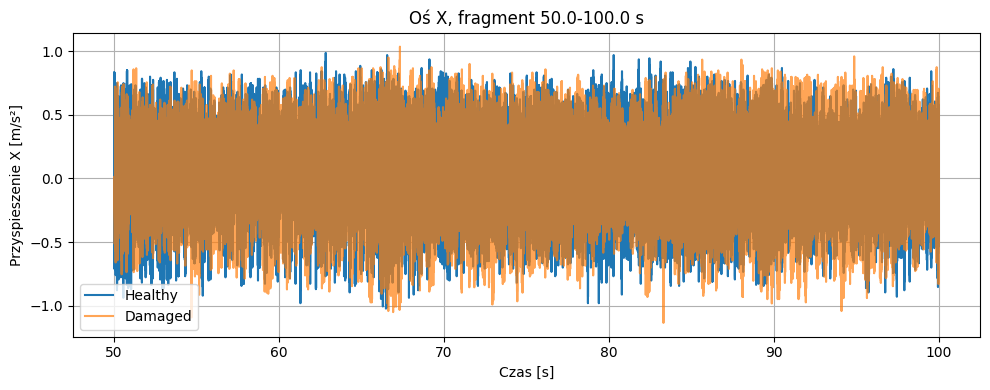

In [4]:
plt.figure()
plt.plot(t_h, x_h, label="Healthy")
plt.plot(t_d, x_d, label="Damaged", alpha=0.7)
plt.xlabel("Czas [s]")
plt.ylabel("Przyspieszenie X [m/s²]")
plt.title(f"Oś X, fragment {T_START}-{T_END} s")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


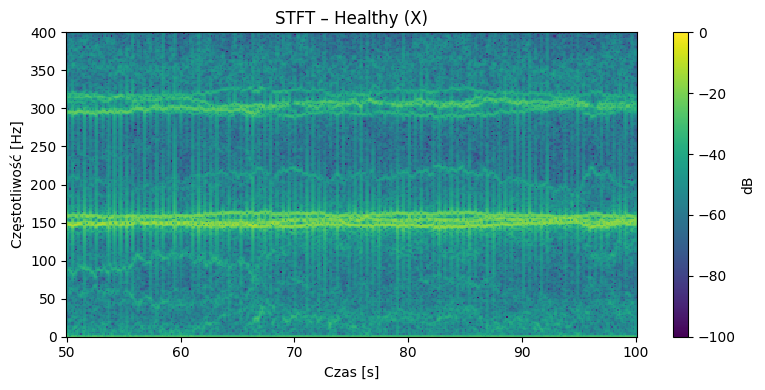

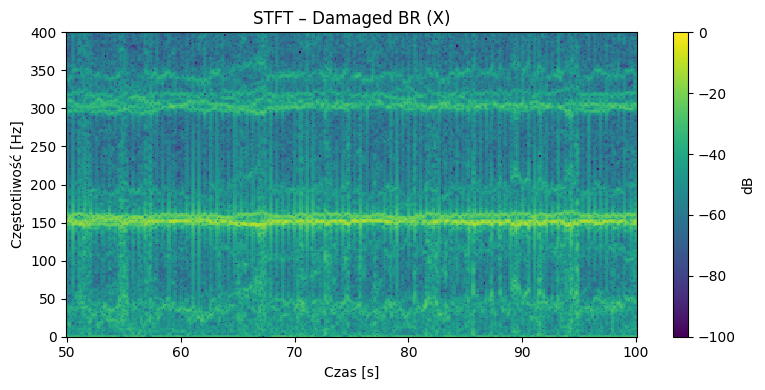

In [5]:
from scipy.signal import stft

def plot_stft(t, x, Fs, title, fmax=400):
    f, tt, Z = stft(x, fs=Fs, window="hann", nperseg=512, noverlap=384)
    Z_db = 20 * np.log10(np.abs(Z) + 1e-12)

    plt.figure(figsize=(8, 4))
    plt.pcolormesh(tt + t[0], f, Z_db, shading="auto", vmin=-100, vmax=0)
    plt.ylim(0, fmax)
    plt.xlabel("Czas [s]")
    plt.ylabel("Częstotliwość [Hz]")
    plt.title(title)
    plt.colorbar(label="dB")
    plt.tight_layout()
    plt.show()

plot_stft(t_h, x_h, Fs_h, "STFT – Healthy (X)")
plot_stft(t_d, x_d, Fs_d, "STFT – Damaged BR (X)")


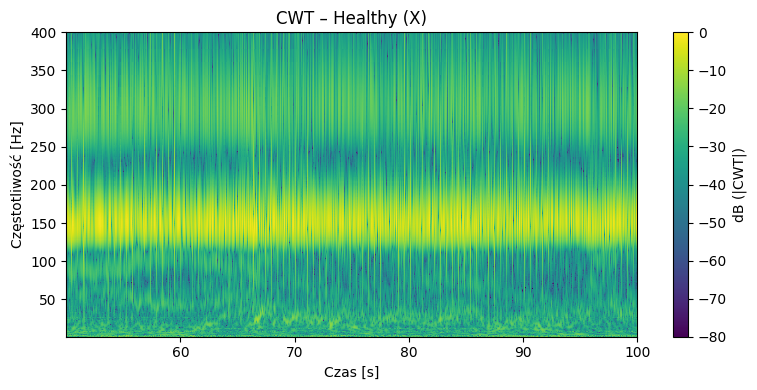

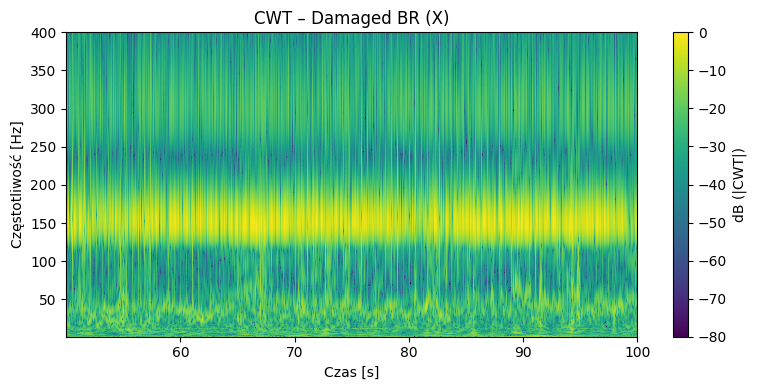

In [38]:
import pywt

def compute_cwt_freq(t, x, Fs, fmin, fmax, n_freqs=300,
                     wavelet="cmor3.5-1.0"):
    """
    Liczy CWT i zwraca:
    - freqs: wektor częstotliwości [Hz] (n_freqs,)
    - power_db: macierz dB o kształcie (n_freqs, len(t))
    """
    dt = 1.0 / Fs

    freqs = np.linspace(fmin, fmax, n_freqs)
    scales = pywt.frequency2scale(wavelet, freqs * dt)

    coeffs, _ = pywt.cwt(x, scales, wavelet, sampling_period=dt)
    power = np.abs(coeffs)
    power_db = 20 * np.log10(power + 1e-12)

    return freqs, power_db

def plot_cwt_from_power(t, freqs, power_db, title,
                        vmin=-80, vmax=0, fmin=None, fmax=None):
    if fmin is None:
        fmin = freqs.min()
    if fmax is None:
        fmax = freqs.max()

    plt.figure(figsize=(8, 4))
    plt.pcolormesh(t, freqs, np.clip(power_db, vmin, vmax),
                   shading="auto", vmin=vmin, vmax=vmax)
    plt.ylim(fmin, fmax)
    plt.xlabel("Czas [s]")
    plt.ylabel("Częstotliwość [Hz]")
    plt.title(title)
    plt.colorbar(label="dB (|CWT|)")
    plt.tight_layout()
    plt.show()

freqs_h, power_db_h = compute_cwt_freq(t_h, x_h, Fs_h, fmin=1, fmax=400)
freqs_d, power_db_d = compute_cwt_freq(t_d, x_d, Fs_d, fmin=1, fmax=400)

plot_cwt_from_power(t_h, freqs_h, power_db_h, "CWT – Healthy (X)")
plot_cwt_from_power(t_d, freqs_d, power_db_d, "CWT – Damaged BR (X)")



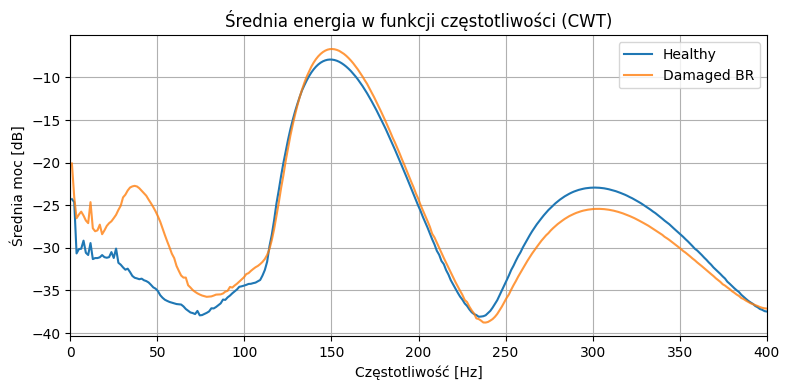

In [39]:
mean_h = power_db_h.mean(axis=1)   # średnia w czasie dla każdej częstotliwości
mean_d = power_db_d.mean(axis=1)

plt.figure(figsize=(8,4))
plt.plot(freqs_h, mean_h, label="Healthy")
plt.plot(freqs_d, mean_d, label="Damaged BR", alpha=0.8)
plt.xlim(0, 400)
plt.xlabel("Częstotliwość [Hz]")
plt.ylabel("Średnia moc [dB]")
plt.title("Średnia energia w funkcji częstotliwości (CWT)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
def band_energy(mean_spec, freqs, f1, f2):
    mask = (freqs >= f1) & (freqs <= f2)
    return mean_spec[mask].mean()

bands = [(50,80), (130,170), (260,340)]

for f1,f2 in bands:
    Eh = band_energy(mean_h, freqs_h, f1, f2)
    Ed = band_energy(mean_d, freqs_d, f1, f2)
    print(f"{f1}-{f2} Hz: healthy={Eh:.1f} dB, damaged={Ed:.1f} dB, różnica={Ed-Eh:+.1f} dB")


50-80 Hz: healthy=-36.9 dB, damaged=-32.5 dB, różnica=+4.4 dB
130-170 Hz: healthy=-9.4 dB, damaged=-8.5 dB, różnica=+0.9 dB
260-340 Hz: healthy=-24.7 dB, damaged=-27.1 dB, różnica=-2.4 dB


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from pathlib import Path

plt.rcParams["figure.figsize"] = (8, 4)

# --- ŚCIEŻKI ---
DATA_DIR = Path("data/daneInternet")
HEALTHY_PATH = DATA_DIR / "Healthy.xlsx"
DAMAGED_PATH = DATA_DIR / "Damaged Bottom Right Blade.xlsx"

def load_case(path: Path) -> pd.DataFrame:
    df = pd.read_excel(path)
    df.columns = [c.strip() for c in df.columns]
    df = df.rename(columns={
        "Time (s)": "time",
        "X Acceleration": "ax",
        "Y Acceleration": "ay",
        "Z Acceleration": "az",
    })
    return df

df_healthy = load_case(HEALTHY_PATH)
df_damaged = load_case(DAMAGED_PATH)

def extract_segment(df: pd.DataFrame, t_start: float, t_end: float):
    """Zwraca (t, x, Fs) dla fragmentu [t_start, t_end) w sekundach."""
    mask = (df["time"] >= t_start) & (df["time"] < t_end)
    seg = df.loc[mask].reset_index(drop=True)
    t = seg["time"].to_numpy()
    x = seg["ax"].to_numpy()
    dt = np.mean(np.diff(t))
    Fs = 1.0 / dt
    return t, x, Fs

# --- definicja okien czasowych ---
segments = [
    (50, 70),
    (70, 90),
    (90, 110),
    (110, 130),
    (130, 150),
]


Dostępne segmenty: [(50, 70), (70, 90), (90, 110), (110, 130), (130, 150)]


In [44]:
def compute_cwt_freq(x, Fs, fmin=1, fmax=400, n_freqs=300,
                     wavelet="cmor3.5-1.0"):
    """
    Liczy CWT i zwraca:
      freqs    – wektor częstotliwości [Hz] (n_freqs,)
      power_db – macierz dB o kształcie (n_freqs, len(x))
    """
    dt = 1.0 / Fs
    freqs = np.linspace(fmin, fmax, n_freqs)
    scales = pywt.frequency2scale(wavelet, freqs * dt)

    coeffs, _ = pywt.cwt(x, scales, wavelet, sampling_period=dt)
    power = np.abs(coeffs)
    power_db = 20 * np.log10(power + 1e-12)
    return freqs, power_db

def plot_cwt_from_power(t, freqs, power_db, title,
                        vmin=-80, vmax=0):
    plt.figure()
    plt.pcolormesh(t, freqs, np.clip(power_db, vmin, vmax),
                   shading="auto", vmin=vmin, vmax=vmax)
    plt.ylim(freqs.min(), freqs.max())
    plt.xlabel("Czas [s]")
    plt.ylabel("Częstotliwość [Hz]")
    plt.title(title)
    plt.colorbar(label="dB (|CWT|)")
    plt.tight_layout()
    plt.show()


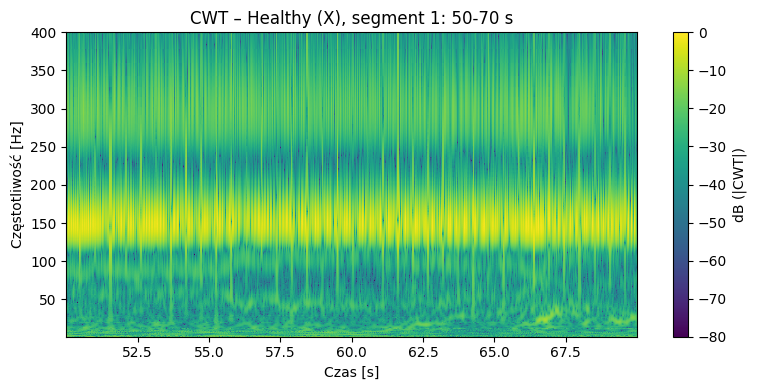

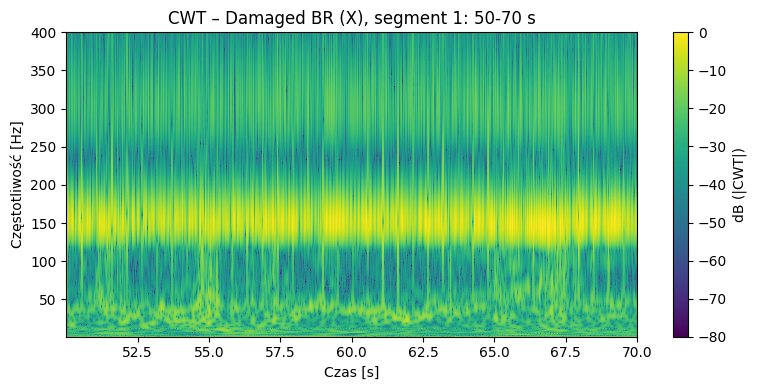

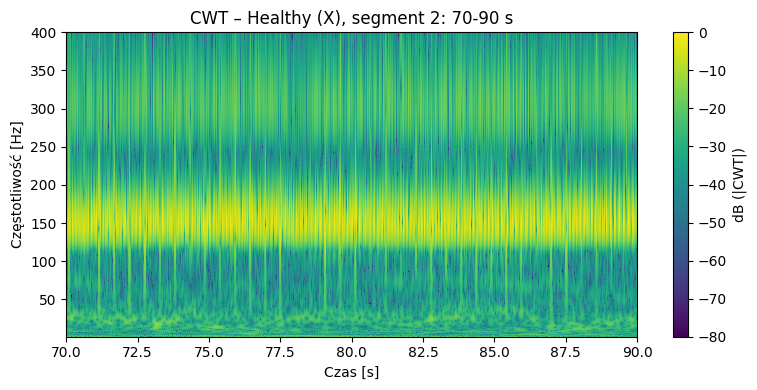

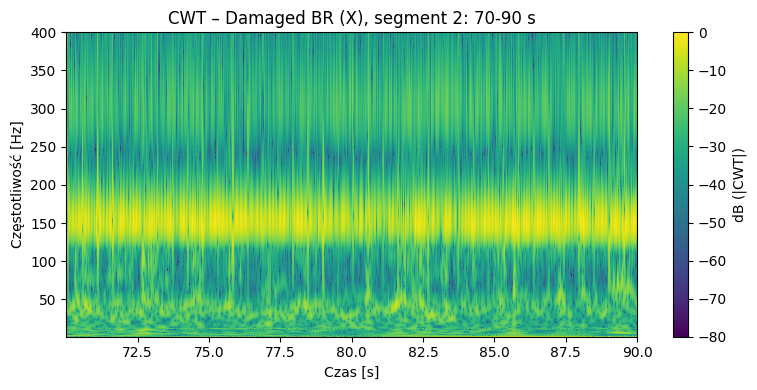

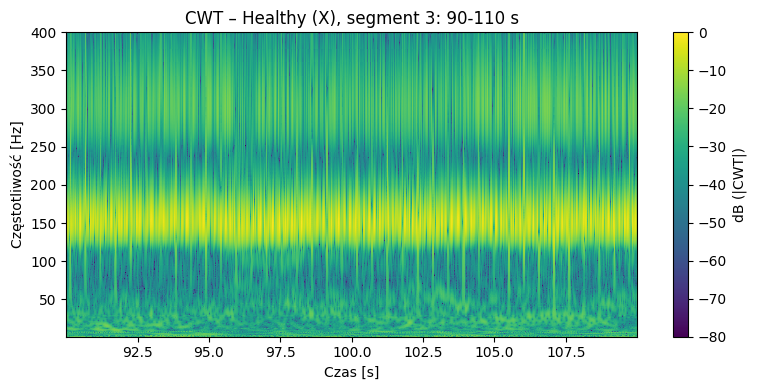

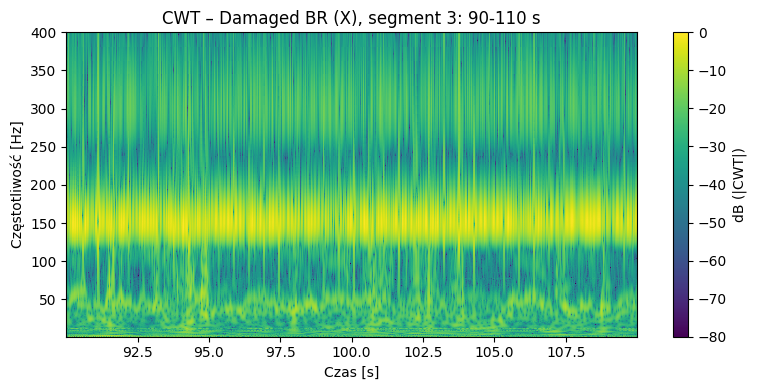

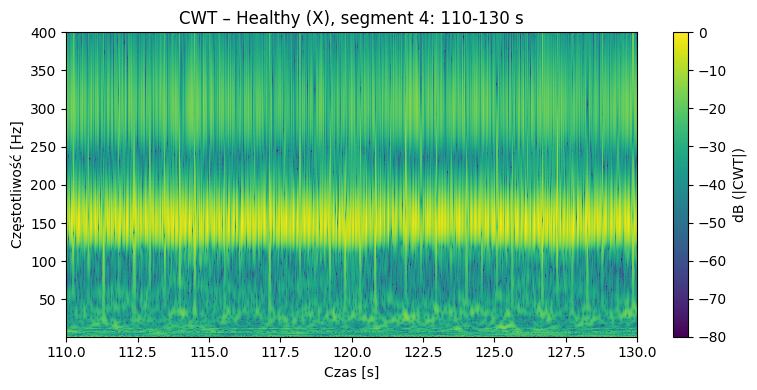

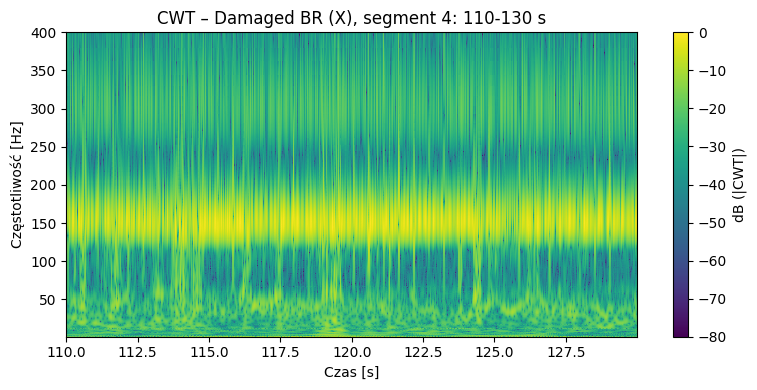

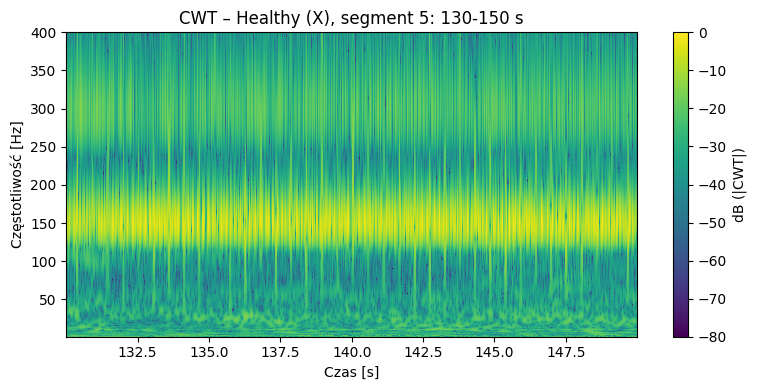

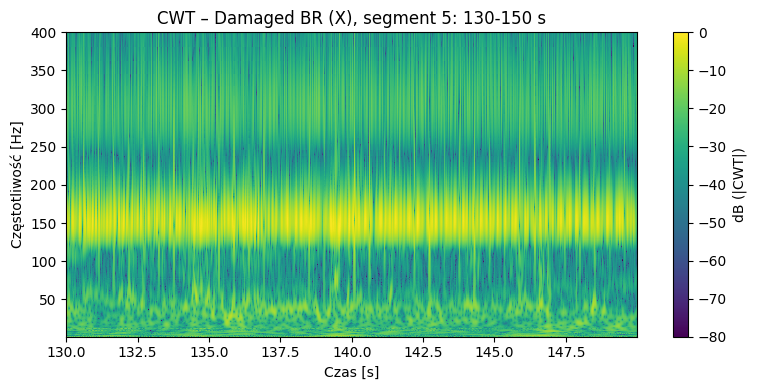

In [45]:
results = {
    "healthy": [],
    "damaged": []
}

for i, (t0, t1) in enumerate(segments, start=1):
    # --- Healthy ---
    t_h, x_h, Fs_h = extract_segment(df_healthy, t0, t1)
    freqs_h, power_db_h = compute_cwt_freq(x_h, Fs_h)

    results["healthy"].append({
        "segment_idx": i,
        "t_range": (t0, t1),
        "t": t_h,
        "Fs": Fs_h,
        "freqs": freqs_h,
        "power_db": power_db_h,
    })

    plot_cwt_from_power(
        t_h, freqs_h, power_db_h,
        f"CWT – Healthy (X), segment {i}: {t0}-{t1} s"
    )

    # --- Damaged ---
    t_d, x_d, Fs_d = extract_segment(df_damaged, t0, t1)
    freqs_d, power_db_d = compute_cwt_freq(x_d, Fs_d)

    results["damaged"].append({
        "segment_idx": i,
        "t_range": (t0, t1),
        "t": t_d,
        "Fs": Fs_d,
        "freqs": freqs_d,
        "power_db": power_db_d,
    })

    plot_cwt_from_power(
        t_d, freqs_d, power_db_d,
        f"CWT – Damaged BR (X), segment {i}: {t0}-{t1} s"
    )



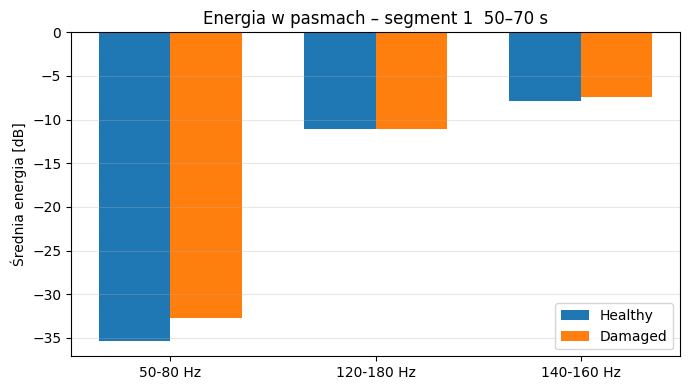

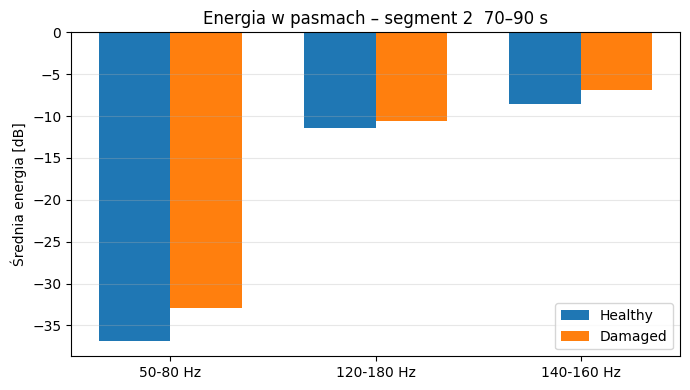

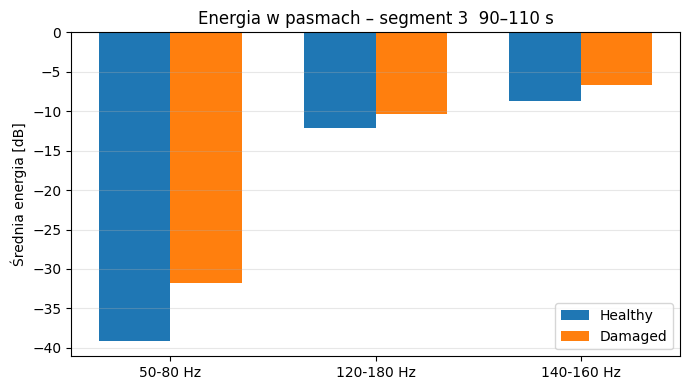

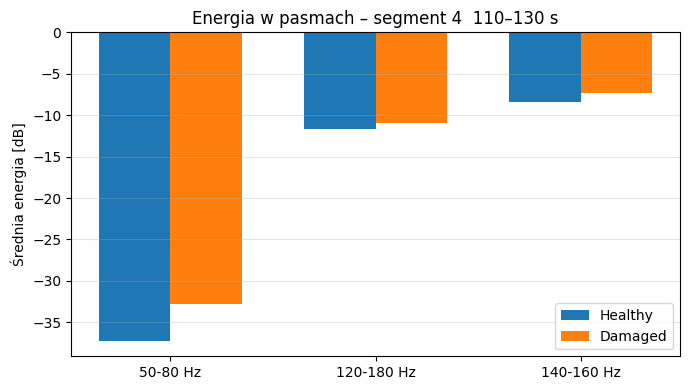

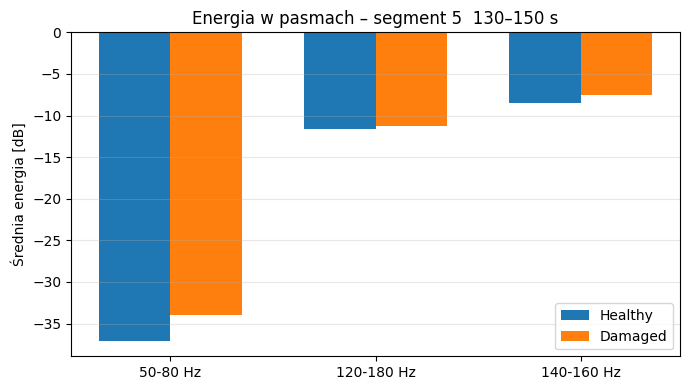

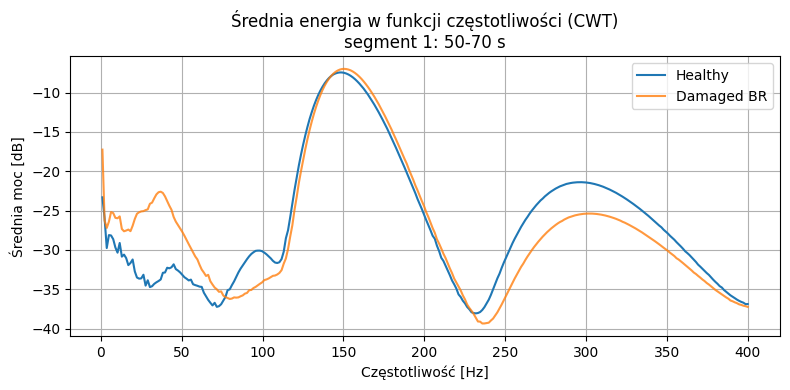

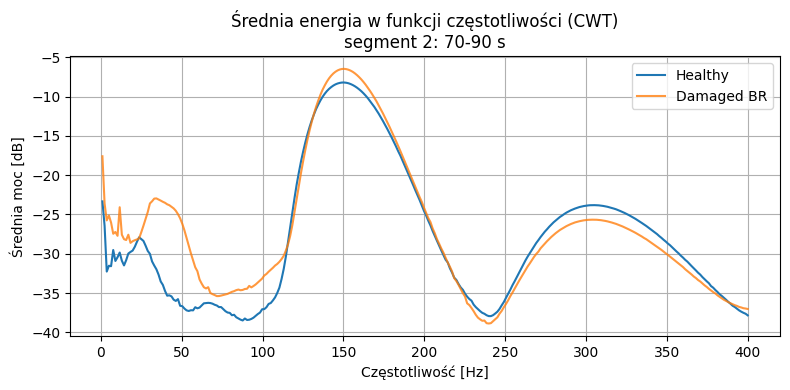

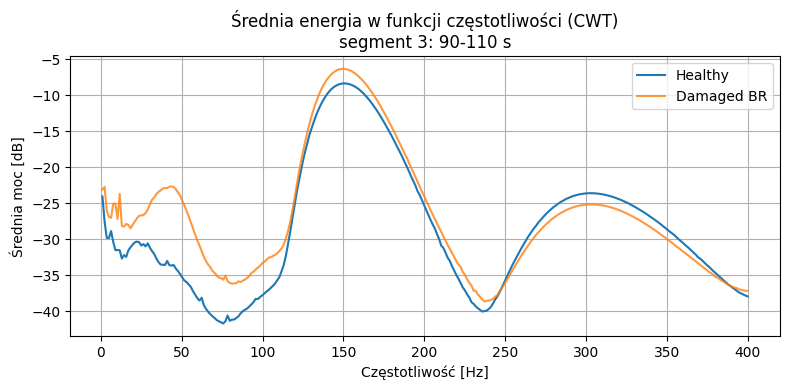

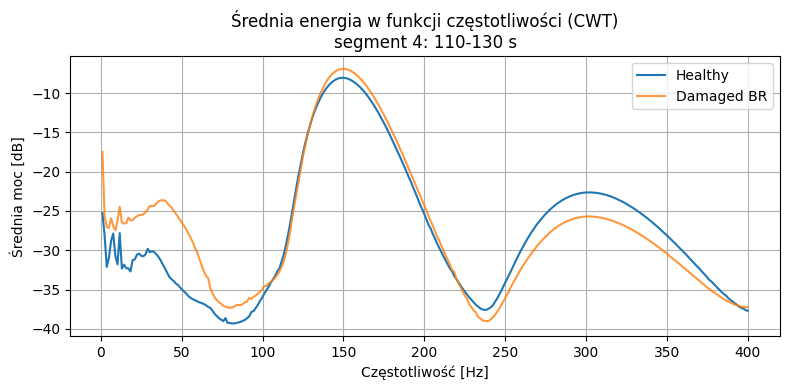

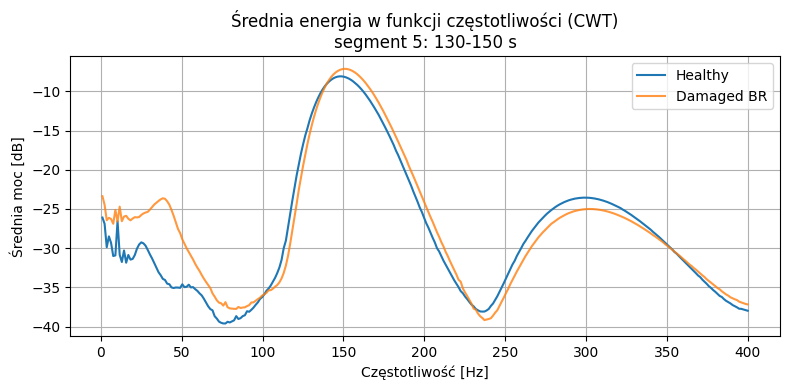


=== HEALTHY ===
Segment 1 (50, 70):
   50- 80 Hz: -35.34 dB
  120-180 Hz: -11.10 dB
  140-160 Hz:  -7.85 dB
Segment 2 (70, 90):
   50- 80 Hz: -36.84 dB
  120-180 Hz: -11.44 dB
  140-160 Hz:  -8.52 dB
Segment 3 (90, 110):
   50- 80 Hz: -39.12 dB
  120-180 Hz: -12.08 dB
  140-160 Hz:  -8.70 dB
Segment 4 (110, 130):
   50- 80 Hz: -37.24 dB
  120-180 Hz: -11.65 dB
  140-160 Hz:  -8.45 dB
Segment 5 (130, 150):
   50- 80 Hz: -37.08 dB
  120-180 Hz: -11.60 dB
  140-160 Hz:  -8.49 dB

=== DAMAGED ===
Segment 1 (50, 70):
   50- 80 Hz: -32.73 dB
  120-180 Hz: -11.03 dB
  140-160 Hz:  -7.39 dB
Segment 2 (70, 90):
   50- 80 Hz: -32.91 dB
  120-180 Hz: -10.60 dB
  140-160 Hz:  -6.89 dB
Segment 3 (90, 110):
   50- 80 Hz: -31.79 dB
  120-180 Hz: -10.39 dB
  140-160 Hz:  -6.73 dB
Segment 4 (110, 130):
   50- 80 Hz: -32.79 dB
  120-180 Hz: -10.91 dB
  140-160 Hz:  -7.35 dB
Segment 5 (130, 150):
   50- 80 Hz: -34.01 dB
  120-180 Hz: -11.31 dB
  140-160 Hz:  -7.56 dB


In [48]:
def band_energy_from_cwt(freqs, power_db, f1, f2):
    """
    Średnia energia (w dB) w paśmie [f1, f2] z macierzy CWT (freqs x time).
    """
    mask = (freqs >= f1) & (freqs <= f2)
    if not np.any(mask):
        return np.nan
    return power_db[mask, :].mean()   # średnia po częstotliwości i czasie

bands = [(50, 80), (120, 180), (140, 160)]
band_labels = [f"{f1}-{f2} Hz" for (f1, f2) in bands]

for seg_idx in range(len(results["healthy"])):
    seg_h = results["healthy"][seg_idx]
    seg_d = results["damaged"][seg_idx]

    freqs_h = seg_h["freqs"]
    P_h = seg_h["power_db"]
    freqs_d = seg_d["freqs"]
    P_d = seg_d["power_db"]

    # zakładamy te same parametry CWT => freqs_h ≈ freqs_d
    E_h = []
    E_d = []

    for (f1, f2) in bands:
        Eh = band_energy_from_cwt(freqs_h, P_h, f1, f2)
        Ed = band_energy_from_cwt(freqs_d, P_d, f1, f2)
        E_h.append(Eh)
        E_d.append(Ed)

    x = np.arange(len(bands))
    w = 0.35  # szerokość słupka

    plt.figure(figsize=(7, 4))
    plt.bar(x - w/2, E_h, width=w, label="Healthy")
    plt.bar(x + w/2, E_d, width=w, label="Damaged")

    plt.xticks(x, band_labels, rotation=0)
    plt.ylabel("Średnia energia [dB]")
    plt.title(f"Energia w pasmach – segment {seg_h['segment_idx']}  "
              f"{seg_h['t_range'][0]}–{seg_h['t_range'][1]} s")
    plt.legend()
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


for seg_h, seg_d in zip(results["healthy"], results["damaged"]):
    idx = seg_h["segment_idx"]
    t0, t1 = seg_h["t_range"]

    freqs_h = seg_h["freqs"]
    P_h = seg_h["power_db"]          # shape: (n_freqs, n_time)
    freqs_d = seg_d["freqs"]
    P_d = seg_d["power_db"]

    # zakładamy te same parametry CWT => freqs_h ≈ freqs_d
    mean_h = P_h.mean(axis=1)        # średnia po czasie
    mean_d = P_d.mean(axis=1)

    plt.figure(figsize=(8, 4))
    plt.plot(freqs_h, mean_h, label="Healthy")
    plt.plot(freqs_d, mean_d, label="Damaged BR", alpha=0.8)
    plt.xlabel("Częstotliwość [Hz]")
    plt.ylabel("Średnia moc [dB]")
    plt.title(f"Średnia energia w funkcji częstotliwości (CWT)\n"
              f"segment {idx}: {t0}-{t1} s")
    plt.grid(True)
    plt.legend()
    # opcjonalnie, jeśli CWT liczyłeś np. 0–400 Hz:
    # plt.xlim(0, 400)
    plt.tight_layout()
    plt.show()



for cls in ["healthy", "damaged"]:
    print(f"\n=== {cls.upper()} ===")
    for seg in results[cls]:
        freqs = seg["freqs"]
        power_db = seg["power_db"]
        print(f"Segment {seg['segment_idx']} {seg['t_range']}:")
        for (f1, f2) in bands:
            E = band_energy_from_cwt(freqs, power_db, f1, f2)
            print(f"  {f1:3.0f}-{f2:3.0f} Hz: {E:6.2f} dB")